### Train a ALM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

fatal: destination path 'nanoVLM_From_Huggingface' already exists and is not an empty directory.
/content/nanoVLM_From_Huggingface
assets			debug_func.py				  nanoALM.ipynb
benchmark-inference.py	debug_tokenizer_dataset_compatibility.py  README.md
benchmark_suite.py	generate.py				  train.py
checkpoints		measure_vram.py
data			models


### Imports and Setup

In [2]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()
# !huggingface-cli login

In [3]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install tqdm
!pip -q install huggingface_hub
!pip -q install librosa
!pip install --upgrade datasets
!pip install --upgrade transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [5]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AudioQACollator, SAVEECollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [6]:
def get_dataloaders(train_cfg, alm_cfg):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = SAVEECollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [7]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

### Add debug

In [8]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder.forward(audio, output_hidden_states=True)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [9]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

#### Supervised learning and Generative Training 監督學習生成式訓練

In [10]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, alm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_alm_checkpoint:
        model = AudioLanguageModel.from_pretrained(alm_cfg.alm_checkpoint_path)
    else:
        model = AudioLanguageModel(alm_cfg)

    print(f"nanoALM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.audio_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # debug_model_dimensions(model, input_ids, audios)  # Debug model dimensions with dummy data
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item()
            # 修改音頻token計算：根據實際的音頻處理方式
            audio_tokens = audios.shape[0] * alm_cfg.mp_target_length  # 使用配置的目標長度
            num_tokens += audio_tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        audios = batch["audio"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                            _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_savee(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
        model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
    try:
        model.push_to_hub(hf_model_name)
    except Exception as e:
        print(f"Error pushing model to hub: {e}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

    # With this code you can test the accuracy of the model on the SAVEE dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing SAVEE Accuracy:")
    # accuracy = test_savee(model, tokenizer, test_loader, device)
    # print(f"SAVEE Accuracy: {accuracy:.4f}")

#### Three-stage training (contrast training, generative training, instruction fine-tuning) 三段式訓練(對比訓練, 生成式訓練, 指令微調)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

def contrastive_loss(audio_embeds, text_embeds, temperature=0.07):
    """对比学习损失"""
    # 池化到固定维度
    audio_pooled = audio_embeds.mean(dim=1)  # [B, hidden_dim]
    text_pooled = text_embeds.mean(dim=1)    # [B, hidden_dim]

    # 归一化
    audio_pooled = F.normalize(audio_pooled, dim=-1)
    text_pooled = F.normalize(text_pooled, dim=-1)

    # 计算相似度矩阵
    logits = torch.matmul(audio_pooled, text_pooled.T) / temperature

    # 对角线为正样本
    labels = torch.arange(logits.size(0)).to(logits.device)

    # 双向对比损失
    loss_a2t = F.cross_entropy(logits, labels)
    loss_t2a = F.cross_entropy(logits.T, labels)

    return (loss_a2t + loss_t2a) / 2

def stable_contrastive_loss(audio_embeds, text_embeds, temperature=0.1):
    """更稳定的对比学习损失"""
    # 使用多种池化策略的组合
    batch_size = audio_embeds.shape[0]
    
    # 1. 均值池化
    audio_mean = audio_embeds.mean(dim=1)
    text_mean = text_embeds.mean(dim=1)
    
    # 2. 最大池化  
    audio_max = audio_embeds.max(dim=1)[0]
    text_max = text_embeds.max(dim=1)[0]
    
    # 3. 加权池化（使用注意力权重）
    audio_weights = F.softmax(audio_embeds.sum(dim=-1), dim=1).unsqueeze(-1)
    audio_weighted = (audio_embeds * audio_weights).sum(dim=1)
    
    text_weights = F.softmax(text_embeds.sum(dim=-1), dim=1).unsqueeze(-1)
    text_weighted = (text_embeds * text_weights).sum(dim=1)
    
    # 组合特征
    audio_pooled = torch.cat([audio_mean, audio_max, audio_weighted], dim=-1)
    text_pooled = torch.cat([text_mean, text_max, text_weighted], dim=-1)
    
    # L2归一化
    audio_pooled = F.normalize(audio_pooled, p=2, dim=-1)
    text_pooled = F.normalize(text_pooled, p=2, dim=-1)
    
    # 计算相似度矩阵
    sim_matrix = torch.matmul(audio_pooled, text_pooled.T) / temperature
    
    # 标签
    labels = torch.arange(batch_size).to(sim_matrix.device)
    
    # 对称对比损失
    loss_a2t = F.cross_entropy(sim_matrix, labels, label_smoothing=0.1)
    loss_t2a = F.cross_entropy(sim_matrix.T, labels, label_smoothing=0.1)
    
    # 添加特征多样性正则化
    diversity_loss = -torch.mean(torch.var(audio_pooled, dim=0)) - torch.mean(torch.var(text_pooled, dim=0))
    
    total_loss = (loss_a2t + loss_t2a) / 2 + 0.01 * diversity_loss
    
    return total_loss

def train_step1_alignment(train_cfg, alm_cfg):
    """第一步：模态投影器对齐训练（包含预训练阶段）"""
    print("=== Stage 1: Modality Projector Alignment (with Pretraining) ===")
    
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    model = AudioLanguageModel(alm_cfg)
    
    # 冻结参数
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # =================== Stage 0.5: MP预训练 ===================
    print("--- Stage 0.5: MP Pretraining with Reconstruction Loss ---")
    
    # 预训练优化器（使用较高学习率）
    pretrain_optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp * 2)
    
    for epoch in range(3):  # 预训练3个epoch
        model.train()
        total_pretrain_loss = 0
        
        for batch in tqdm(train_loader, desc=f"MP Pretrain Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            
            pretrain_optimizer.zero_grad()
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 获取音频特征
                input_features = audios.to(device)
                with torch.no_grad():
                    encoder_outputs = model.audio_encoder.encoder(input_features, output_hidden_states=True)
                
                audio_features = encoder_outputs.last_hidden_state  # [B, T, D]
                
                # 通过MP投影
                audio_embeds = model.MP(audio_features)  # [B, target_length, lm_hidden_dim]
                
                # 创建重构目标：将原始特征池化到目标长度
                # 方法1：自适应平均池化
                target_features = F.adaptive_avg_pool1d(
                    audio_features.transpose(1, 2),  # [B, D, T]
                    audio_embeds.shape[1]  # target_length
                ).transpose(1, 2)  # [B, target_length, D]
                
                # 通过线性层调整维度匹配
                if not hasattr(model, 'pretrain_proj'):
                    model.pretrain_proj = nn.Linear(
                        audio_features.shape[-1], 
                        audio_embeds.shape[-1]
                    ).to(device)
                
                target_embeds = model.pretrain_proj(target_features)
                
                # MSE重构损失
                recon_loss = F.mse_loss(audio_embeds, target_embeds)
            
            recon_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            pretrain_optimizer.step()
            
            total_pretrain_loss += recon_loss.item()
        
        avg_pretrain_loss = total_pretrain_loss / len(train_loader)
        print(f"MP Pretrain Epoch {epoch+1}: Reconstruction Loss {avg_pretrain_loss:.4f}")
    
    print("MP Pretraining completed! Starting contrastive learning...")
    
    # =================== Stage 1: 对比学习 ===================
    
    # 对比学习优化器（使用较低学习率）
    optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp * 0.5, weight_decay=0.01)
    
    # 学习率调度器
    total_steps = len(train_loader) * train_cfg.stage1_epochs
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=train_cfg.lr_mp * 0.5,
        total_steps=total_steps,
        pct_start=0.1,
        anneal_strategy='cos'
    )

    batch_losses = []
    best_loss = float('inf')
    global_step = 0
    
    for epoch in range(train_cfg.stage1_epochs):
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Stage1 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            
            optimizer.zero_grad()
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 音频编码
                input_features = audios.to(device)
                with torch.no_grad():
                    encoder_outputs = model.audio_encoder.encoder(input_features, output_hidden_states=True)
                
                audio_features = encoder_outputs.last_hidden_state
                audio_embeds = model.MP(audio_features)
                
                # 文本编码
                text_embeds = model.decoder.token_embedding(input_ids[:, :-1])
                
                # 对比学习损失
                loss = stable_contrastive_loss(audio_embeds, text_embeds)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)
            
            if global_step % 100 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Step {global_step}: Loss {batch_loss:.4f}, LR {current_lr:.2e}")
            
            global_step += 1
        
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Stage1 Epoch {epoch+1}: Contrastive Loss {avg_train_loss:.4f}")
        
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_best")
    
    # 清理预训练用的临时层
    if hasattr(model, 'pretrain_proj'):
        delattr(model, 'pretrain_proj')
    
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_final")
    print("Stage 1 completed!")
    
    # 绘制损失曲线
    plt.plot(batch_losses, label='Contrastive Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Stage 1: Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return model

def train_step2_pretraining(train_cfg, alm_cfg, stage1_model=None):
    """第二步：语言模型预训练"""
    print("=== Stage 2: Language Model Pretraining ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型或从头开始
    if stage1_model is not None:
        model = stage1_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage1_final")
            print("Loaded Stage 1 model")
        except:
            model = AudioLanguageModel(alm_cfg)
            print("Starting Stage 2 from scratch")

    # 冻结音频编码器，解冻语言模型和模态投影器
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Stage 2: Training {trainable_params:,} parameters")

    # 不同学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.1},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 使用因果语言建模损失
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            # 动态学习率调整
            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp * 0.1, len(train_loader) * train_cfg.stage2_epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.stage2_epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_best")

    # 保存第二阶段模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final")
    print("Stage 2 completed!")
    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model=None):
    """第三步：指令微调"""
    print("=== Stage 3: Instruction Tuning ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第二阶段模型
    if stage2_model is not None:
        model = stage2_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage2_final")
            print("Loaded Stage 2 model")
        except:
            print("No Stage 2 model found, using current model")
            model = AudioLanguageModel(alm_cfg)

    # 全部解冻，使用较小学习率
    for param in model.parameters():
        param.requires_grad = True

    print(f"Stage 3: Training all {sum(p.numel() for p in model.parameters()):,} parameters")

    # 更小的学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.01},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones * 0.1},
        {'params': model.audio_encoder.parameters(), 'lr': train_cfg.lr_backbones * 0.01}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    # 这里可以使用原来的训练循环，但数据应该是指令格式
    # 暂时使用相同的数据格式
    best_accuracy = 0
    global_step = 0

    for epoch in range(train_cfg.stage3_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage3 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss

            if global_step % 50 == 0:
                print(f"Stage3 Step: {global_step}, Instruction Loss: {batch_loss:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        # 评估性能
        if train_cfg.eval_in_epochs:
            accuracy = test_savee(model, tokenizer, test_loader, device)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage3_best")
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {accuracy:.4f}")
        else:
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Instruction Loss: {avg_train_loss:.4f}")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/final_model")
    print("Stage 3 completed!")
    return model

def train_three_stages(train_cfg, alm_cfg):
    """完整的三阶段训练"""
    print("Starting Three-Stage Training Pipeline")

    # 第一阶段：模态投影器对齐
    stage1_model = train_step1_alignment(train_cfg, alm_cfg)

    # 第二阶段：语言模型预训练
    stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)

    # 第三阶段：指令微调
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)

    print("=== Training Pipeline Completed! ===")
    return stage1_model, stage2_model, final_model


# # 替换原来的训练调用
# alm_cfg = ALMConfig()
# train_cfg = TrainConfig()

# # 运行三阶段训练
# final_model = train_three_stages(train_cfg, alm_cfg)

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [ ]:
@dataclass
class ALMConfig:
    audio_hidden_dim: int = 768
    audio_inter_dim: int = 4 * audio_hidden_dim
    audio_patch_size: int = 16  # 音频patch大小（时间步数）
    audio_n_heads: int = 12
    audio_dropout: float = 0.0
    audio_n_blocks: int = 12
    audio_ln_eps: float = 1e-6
    # audio_model_type: str = 'custom_audio_transformer'
    # 如果使用 nvidia/parakeet-tdt-0.6b-v2, 以上參數將不會發生作用
    # audio_model_type: str = 'nvidia/parakeet-tdt-0.6b-v2' # asr model for encoder from huggingface
    # audio_model_type: str = 'openai/whisper-large-v3' # asr model for encoder from huggingface
    audio_model_type: str = 'openai/whisper-small.en' # asr model for encoder from huggingface

    # 音频处理相关参数
    audio_sample_rate: int = 16000  # 采样率
    audio_n_fft: int = 400  # FFT窗口大小
    audio_hop_length: int = 160  # 跳跃长度
    audio_n_mels: int = 80  # 梅尔滤波器数量
    audio_max_length: int = 1500  # 最大时间步数

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_use_tokens: bool = False
    lm_tie_weights: bool = True
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'

    # 模態投影器配置
    mp_projection_type: str = 'adaptive' # adaptive, transformer, hybrid
    mp_target_length: int = 25
    mp_use_position_aware: bool = True

    # 計算語言模型最大長度
    lm_max_length: int = 128 - mp_target_length  # 總長度 - 音頻token長度

    # ALM特定配置
    alm_load_backbone_weights: bool = True
    alm_checkpoint_path: str = 'checkpoints'
    alm_name: str = 'nanoALM-222M'
    mp_hidden_multiplier = 2
    mp_dropout = 0.1


@dataclass
class TrainConfig:
    mp_pretrain_epochs: int = 3
    mp_pretrain_lr: float = 1e-4  # 预训练使用较高学习率

    lr_mp: float = 5e-5
    lr_backbones: float = 5e-6
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 8  # 减小以适应三阶段训练
    savee_batch_size: int = 8

    # epochs: int = 20
    stage1_epochs: int = 10   # 模态对齐
    stage2_epochs: int = 10  # 预训练
    stage3_epochs: int = 5   # 指令微调

    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of SAVEE every time otherwise
    resume_from_alm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole ALM or you want to start from scratch

    # train_dataset_path: str = 'AbstractTTS/IEMOCAP'
    # train_dataset_name: tuple[str, ...] = ('default', ) #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",

    # train_dataset_path: str = 'speechbrain/LoquaciousSet'
    # train_dataset_name: tuple[str, ...] = ('medium', ) # small, medium

    train_dataset_path: str = 'MLCommons/peoples_speech'
    train_dataset_name: tuple[str, ...] = ('clean_sa', ) # small, medium
    test_dataset_path: str = "AbstractTTS/SAVEE"


### Lets run the training!

In [13]:
import os
# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'checkpoints' already exists.


Starting Three-Stage Training Pipeline
=== Stage 1: Modality Projector Alignment ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Loading from backbone weights
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
nanoALM initialized with 376,691,520 parameters
Stage 1: Only training 442,368 MP parameters


Stage1 Epoch 5: 100%|██████████| 102/102 [00:25<00:00,  4.07it/s]


Stage 1 completed!


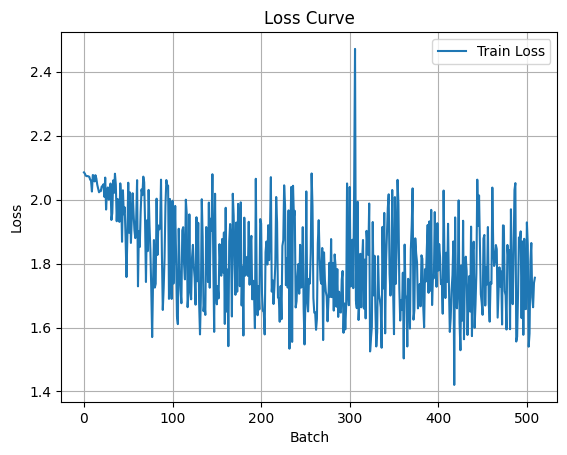

=== Stage 2: Language Model Pretraining ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Stage 2: Training 134,957,376 parameters


Stage2 Epoch 1:   1%|          | 1/102 [00:05<08:38,  5.14s/it]

Stage2 Step: 0, Pretraining Loss: 3.8273


Stage2 Epoch 1:  50%|█████     | 51/102 [01:15<01:17,  1.53s/it]

Stage2 Step: 50, Pretraining Loss: 3.0569


Stage2 Epoch 1:  99%|█████████▉| 101/102 [02:27<00:01,  1.43s/it]

Stage2 Step: 100, Pretraining Loss: 3.1046


Stage2 Epoch 1: 100%|██████████| 102/102 [02:28<00:00,  1.46s/it]


Stage2 Epoch 1/10 | Pretraining Loss: 3.3778


Stage2 Epoch 2:  48%|████▊     | 49/102 [01:11<01:11,  1.35s/it]

Stage2 Step: 150, Pretraining Loss: 2.4677


Stage2 Epoch 2:  97%|█████████▋| 99/102 [02:21<00:04,  1.40s/it]

Stage2 Step: 200, Pretraining Loss: 2.7842


Stage2 Epoch 2: 100%|██████████| 102/102 [02:25<00:00,  1.43s/it]


Stage2 Epoch 2/10 | Pretraining Loss: 2.9462


Stage2 Epoch 3:  46%|████▌     | 47/102 [01:08<01:13,  1.34s/it]

Stage2 Step: 250, Pretraining Loss: 2.7262


Stage2 Epoch 3:  95%|█████████▌| 97/102 [02:19<00:07,  1.48s/it]

Stage2 Step: 300, Pretraining Loss: 2.4698


Stage2 Epoch 3: 100%|██████████| 102/102 [02:26<00:00,  1.44s/it]


Stage2 Epoch 3/10 | Pretraining Loss: 2.8425


Stage2 Epoch 4:  44%|████▍     | 45/102 [01:05<01:17,  1.35s/it]

Stage2 Step: 350, Pretraining Loss: 2.3941


Stage2 Epoch 4:  93%|█████████▎| 95/102 [02:15<00:09,  1.39s/it]

Stage2 Step: 400, Pretraining Loss: 2.8997


Stage2 Epoch 4: 100%|██████████| 102/102 [02:25<00:00,  1.43s/it]


Stage2 Epoch 4/10 | Pretraining Loss: 2.7677


Stage2 Epoch 5:  42%|████▏     | 43/102 [01:03<01:20,  1.37s/it]

Stage2 Step: 450, Pretraining Loss: 2.3702


Stage2 Epoch 5:  91%|█████████ | 93/102 [02:13<00:13,  1.50s/it]

Stage2 Step: 500, Pretraining Loss: 2.8811


Stage2 Epoch 5: 100%|██████████| 102/102 [02:26<00:00,  1.43s/it]


Stage2 Epoch 5/10 | Pretraining Loss: 2.7021


Stage2 Epoch 6:  40%|████      | 41/102 [01:00<01:22,  1.35s/it]

Stage2 Step: 550, Pretraining Loss: 2.8590


Stage2 Epoch 6:  89%|████████▉ | 91/102 [02:10<00:14,  1.36s/it]

Stage2 Step: 600, Pretraining Loss: 2.2493


Stage2 Epoch 6: 100%|██████████| 102/102 [02:25<00:00,  1.43s/it]


Stage2 Epoch 6/10 | Pretraining Loss: 2.6314


Stage2 Epoch 7:  38%|███▊      | 39/102 [00:58<01:24,  1.35s/it]

Stage2 Step: 650, Pretraining Loss: 2.6015


Stage2 Epoch 7:  87%|████████▋ | 89/102 [02:08<00:18,  1.40s/it]

Stage2 Step: 700, Pretraining Loss: 2.7886


Stage2 Epoch 7: 100%|██████████| 102/102 [02:26<00:00,  1.43s/it]


Stage2 Epoch 7/10 | Pretraining Loss: 2.5948


Stage2 Epoch 8:  36%|███▋      | 37/102 [00:55<01:32,  1.42s/it]

Stage2 Step: 750, Pretraining Loss: 2.6900


Stage2 Epoch 8:  85%|████████▌ | 87/102 [02:05<00:22,  1.51s/it]

Stage2 Step: 800, Pretraining Loss: 2.4852


Stage2 Epoch 8: 100%|██████████| 102/102 [02:25<00:00,  1.43s/it]


Stage2 Epoch 8/10 | Pretraining Loss: 2.5572


Stage2 Epoch 9:  34%|███▍      | 35/102 [00:52<01:32,  1.39s/it]

Stage2 Step: 850, Pretraining Loss: 2.4317


Stage2 Epoch 9:  83%|████████▎ | 85/102 [02:02<00:24,  1.41s/it]

Stage2 Step: 900, Pretraining Loss: 2.4018


Stage2 Epoch 9: 100%|██████████| 102/102 [02:26<00:00,  1.44s/it]


Stage2 Epoch 9/10 | Pretraining Loss: 2.5447


Stage2 Epoch 10:  32%|███▏      | 33/102 [00:49<01:46,  1.55s/it]

Stage2 Step: 950, Pretraining Loss: 2.2707


Stage2 Epoch 10:  81%|████████▏ | 83/102 [01:58<00:25,  1.34s/it]

Stage2 Step: 1000, Pretraining Loss: 2.8571


Stage2 Epoch 10: 100%|██████████| 102/102 [02:26<00:00,  1.43s/it]


Stage2 Epoch 10/10 | Pretraining Loss: 2.5208
Stage 2 completed!


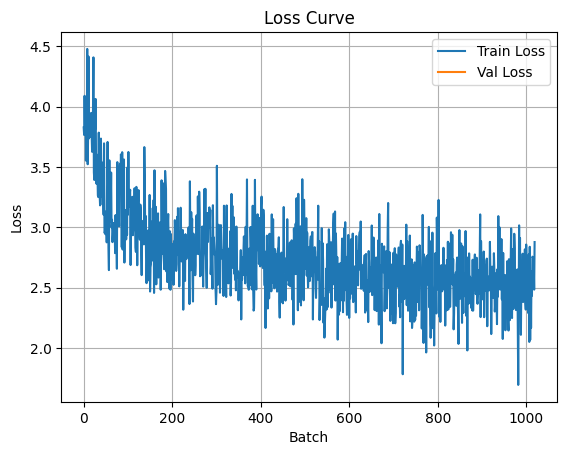

=== Stage 3: Instruction Tuning ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Stage 3: Training all 376,691,520 parameters


Stage3 Epoch 1:   1%|          | 1/102 [00:04<07:03,  4.19s/it]

Stage3 Step: 0, Instruction Loss: 2.6858


Stage3 Epoch 1:  50%|█████     | 51/102 [01:14<01:11,  1.40s/it]

Stage3 Step: 50, Instruction Loss: 2.6852


Stage3 Epoch 1:  99%|█████████▉| 101/102 [02:24<00:01,  1.40s/it]

Stage3 Step: 100, Instruction Loss: 2.1917


Stage3 Epoch 1: 100%|██████████| 102/102 [02:26<00:00,  1.43s/it]


Stage3 Epoch 1/5 | Instruction Loss: 2.5202


Stage3 Epoch 2:  48%|████▊     | 49/102 [01:11<01:14,  1.41s/it]

Stage3 Step: 150, Instruction Loss: 2.7551


Stage3 Epoch 2:  97%|█████████▋| 99/102 [02:21<00:04,  1.51s/it]

Stage3 Step: 200, Instruction Loss: 2.6967


Stage3 Epoch 2: 100%|██████████| 102/102 [02:25<00:00,  1.42s/it]


Stage3 Epoch 2/5 | Instruction Loss: 2.5053


Stage3 Epoch 3:  46%|████▌     | 47/102 [01:09<01:23,  1.53s/it]

Stage3 Step: 250, Instruction Loss: 2.4901


Stage3 Epoch 3:  95%|█████████▌| 97/102 [02:18<00:06,  1.33s/it]

Stage3 Step: 300, Instruction Loss: 2.3979


Stage3 Epoch 3: 100%|██████████| 102/102 [02:26<00:00,  1.43s/it]


Stage3 Epoch 3/5 | Instruction Loss: 2.4923


Stage3 Epoch 4:  44%|████▍     | 45/102 [01:05<01:16,  1.33s/it]

Stage3 Step: 350, Instruction Loss: 2.1853


Stage3 Epoch 4:  93%|█████████▎| 95/102 [02:15<00:09,  1.34s/it]

Stage3 Step: 400, Instruction Loss: 2.4532


Stage3 Epoch 4: 100%|██████████| 102/102 [02:25<00:00,  1.42s/it]


Stage3 Epoch 4/5 | Instruction Loss: 2.4868


Stage3 Epoch 5:  42%|████▏     | 43/102 [01:03<01:20,  1.37s/it]

Stage3 Step: 450, Instruction Loss: 2.4397


Stage3 Epoch 5:  91%|█████████ | 93/102 [02:13<00:12,  1.39s/it]

Stage3 Step: 500, Instruction Loss: 2.3647


Stage3 Epoch 5: 100%|██████████| 102/102 [02:25<00:00,  1.43s/it]


Stage3 Epoch 5/5 | Instruction Loss: 2.4718
Stage 3 completed!
=== Training Pipeline Completed! ===


In [ ]:
alm_cfg = ALMConfig()
train_cfg = TrainConfig()

# trained_model = train(train_cfg, alm_cfg)
stage1_model = train_step1_alignment(train_cfg, alm_cfg)
# stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)
# final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)
# stage1_model, stage2_model, final_model = train_three_stages(train_cfg, alm_cfg)

stage1_model.save_pretrained("/content/")
# stage2_model.save_pretrained("/content/")
# final_model.save_pretrained("/content/")

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

### Test

In [18]:
!cp /content/drive/MyDrive/nanoALM/output_txt1.wav /content/output_txt1.wav
!cp /content/drive/MyDrive/nanoALM/output_txt2.wav /content/output_txt2.wav
!cp /content/drive/MyDrive/nanoALM/output_txt3.wav /content/output_txt3.wav

/bin/bash: line 1: generate.py: command not found


In [29]:
stage1_model.save_pretrained("/content/")
!python generate.py

2025-06-25 08:19:19.734448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750839559.769232   34976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750839559.779186   34976 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240

Input:
   

Outputs:
  >> Generation 1:   That's the end of the story.  That's the end of the story.  No more.